# Neural Networks (part 1)

## 1. Introduction 
Start by watching the following youtube video from 3blue1brown for a nice introduction in the concepts of neural networks (NN). The example that is used in the video is about handwriting digits classification. You will build a neural network that does exactly that.

The link to the video: https://www.youtube.com/watch?v=aircAruvnKk

Refer to the lecture notes on Canvas for the mathematical description of the network. In this notebook we will use the same names and conventions as used in the lecture notes.

## 2. Loading the data

In this notebook you will use a NN to classify the dataset `NNdata1.txt`. It contains the scores of $M$ students, their scores on two separte tests, and the label (0/1) wether they passed the course or not.

**Notebook aim:** Build a NN model to predict wether a student will pass or not based on the two inputs of the two test scores.

In [159]:
# importing the required modules
import numpy as np
import matplotlib.pyplot as plt

# to get matplot figures render correctly in the notebook use:
%matplotlib inline 

In [161]:
# load the data
FILENAME = './NNdata1.txt'
DELIMITER = ',' 

data = np.loadtxt(FILENAME, delimiter=DELIMITER)
#print(data)

## 3. Create the feature matrix X and labels matrix Y

The data that is fed into the NN constist of column vectors $\textbf x_i$ containing the features of the sample $i$. Because usually many samples are required to train and test the NN it is computationally not very efficient to pass them one-by-one. Therefore we have to write the code such that a whole batch of samples can be passed through the network simultaneously. To do so the data is organised in 2 matrices $\textbf X$ and $\textbf Y$
The feature matrix $\textbf X$ contains the features $\textbf x_i$ of the different samples as columns. If we have $m$ samples then $\textbf X \in \mathbb{R}^{n_0 \times m}$. $\color{red}\text{Note that this is different than used sofar!}$

For every sample $\textbf x_i$ a corresponding column vector $\textbf y_i$ exists that gives the category to which the sample belongs. The vector $\textbf y_i$ is a so-called one-hot-encoded label and has $n_L$ (the number of nodes in the output layer) elements. Since each output node of the NN corresponds to one of the possible categories to which a sample belongs, the element of the vector $\textbf y_i$ that corresponds to the category of the sample is equal to 1 and all other elements are zero. For example, if we have two categories '0' and '1' (as is the case in the current problem where the student is either rejected or accepted), and let's say we have 4 samples belonging to category 1, 0, 0, 1 respectively then $\textbf Y$ is given by:

$$ \textbf Y = \begin{bmatrix}
0 & 1 & 1 & 0\\ 
1 & 0 & 0 & 1
\end{bmatrix} $$

The matrix $\textbf Y$ contains the one-hot encoded labels $\textbf y_i$ of the samples as columns. If we have $m$ samples then $\textbf Y \in \mathbb{R}^{n_L \times m}$

In [162]:
#create feature matrix
X = data[:,:2]
print(X.shape)

#apply feature scaling to the matix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
scaler = StandardScaler()
X = scaler.fit_transform(X)
X=X.T
#print(X)

#create one-hot encoded Y matrix
Y = data[:,2]
#print(Y)
Y = np.eye(2)[Y.astype(int)]
Y=Y.T
#print(Y)

(100, 2)


Next you need to split $X$ and $Y$ in a training set (data used to train the network) and a test set (data used to test the network). Normally you would also use a validation set to tune hyperparameters of the model/training but we leave that to part 2 of the NN notebook

In [163]:
# create a train and test dataset with size-ratio 9:1
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y.T, test_size=0.1, random_state=42)
X_train, X_test, Y_train, Y_test = X_train.T, X_test.T, Y_train.T, Y_test.T

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (2, 90)
X_test shape: (2, 10)
Y_train shape: (2, 90)
Y_test shape: (2, 10)


## 4. The Neural Network

The NN that you will make has the following layout:

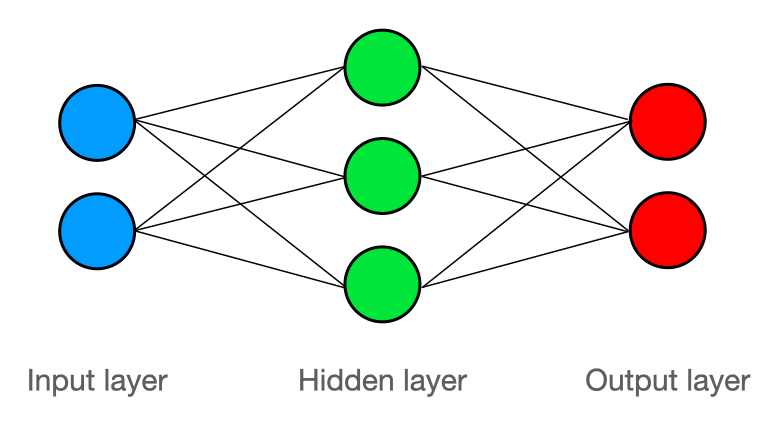

It consists of an input layer with two nodes because each sample consists of two features (score test 1 and score test 2). Then we have one hidden layer consisting of three nodes. Finally the output layer has two nodes corresponding to the two categories that need to be distinghuished.

The hidden layer has a **sigmoid** activation function while the outputlayer has a **softmax** activation function. 

### Define the activation functions

Below you define the required activation functions and their derivatives

In [164]:
# define some activation functions

def sigmoid(z):
    """
    returns the sigmoid function of z

    Parameters
    ----------
    z : float or ndarray

    Returns
    -------
    out : same type and shape as z

    """
    z = np.float64(z)  
    return 1 / (1 + np.exp(-z))


def sigmoid_diff(z):
    """
    returns the derivative of the sigmoid function of z

    Parameters
    ----------
    z : float or ndarray

    Returns
    -------
    out : same type and shape as z

    """
    s = sigmoid(z)
    return s * (1-s)


def softmax(z):
    """
    returns the softmax function of z

    Parameters
    ----------
    z : 2D ndarray

    Returns
    -------
    out : same type and shape as z

    """
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=0)


### Initalize the weights and biases
The layers are denoted with $l$. Our NN has an input layer ($l=0$), an output layer ($l=L=2$) and a hidden layer ($l=1$).

For each layer $l$ we have:
1. A number of nodes: $n_l$
2. A weight matrix: $\textbf W^{l} \in \mathbb{R}^{n_l \times n_{l-1}}$
3. A bias (column) vector: $\textbf b^{l} \in \mathbb{R}^{n_l \times 1}$

The input layer actually does not do much, it just passes the sample data to the output which then acts as input for the first hidden layer. So the input layer does not have a weight and bias.

The biases can be initialized with zeros; the weight's of layer $l$ are best intialized with random numbers from a normal distribution with mean 0 and standard deviation of $\sqrt{1/n_{l-1}}$. 

In [266]:
# intialize the neural network

# number of nodes in each layer
n0 = 2
n1 = 3
n2 = 2

# input layer
# no weights and biases

# hidden layer (l=1)
W1 = np.random.normal(scale=np.sqrt(1/n0), size=(n1,n0))
b1 = np.zeros((n1,1))

# output layer (l=2)
W2 = np.random.normal(scale=np.sqrt(1/n1), size=(n2,n1))
b2 = np.zeros((n2,1))

## 5. Train the NN

Firt you define three parameters that can be adjusted for optimal training.
- **learning_rate**: determines to what extend we update the weights and biases in the gradient descent step
- **no_epochs**: the number of times we pass the training data set through the network for training
- **batch_size**: how many samples we pass through the network before doing a gradient descent update

In [267]:
# train settings
learning_rate = 0.1
no_epochs = 1500
batch_size = 10

Below you implement the training of the network. A general layout (pseudocode) is already given. Note that we use the **Cross Entropy** (CE) loss function.

In [268]:
train_losses = []
train_accuracies = []
total_losses = []
total_accuracies = []
m = X_train.shape[1]  
indices = np.arange(m)


def binary_crossentropy(Y, A):
    return -np.mean(np.sum(Y * np.log(A), axis=0))  # sum over classes, then average over samples
    
def accuracy_score(Y, A):
    pred_labels = np.argmax(A, axis=0)
    true_labels = np.argmax(Y, axis=0)
    return np.mean(pred_labels == true_labels)
    
    
for epoch in range(1, no_epochs + 1):
    np.random.shuffle(indices)
    epoch_loss = 0.0
    epoch_correct = 0.0
    for start_col in range(0,m,batch_size):
        end_col = start_col + batch_size
        
        batch_idx = indices[start_col:end_col]
        
        X_batch = X_train[:, batch_idx] 
        Y_batch = Y_train[:, batch_idx]
        
        # forward pass
        # compute the output of the network for the batch
        z1 = W1 @ X_batch + b1
        a1 = sigmoid(z1)        
        z2 = W2 @ a1 + b2
        a2 = softmax(z2)  
        #output_train = a2
        
        # loss and accuracy
        batch_loss = binary_crossentropy(Y_batch, a2)
        batch_acc = accuracy_score(Y_batch, a2) 
        
        # accumulate the loss for average of entire epoch
        epoch_correct += batch_acc * batch_size
        epoch_loss += batch_loss * batch_size
        
        # backward pass
        # compute the derivatives dLdW and dLdb for the layers (use CE loss)
        dz2 = a2 - Y_batch  # shape (n2, batch_size)
        dW2 = (dz2 @ a1.T) / batch_size       
        db2 = np.sum(dz2, axis=1, keepdims=True) / batch_size                   

        # hidden layer
        dz1 = (W2.T @ dz2) * sigmoid_diff(z1)       
        dW1 = (dz1 @ X_batch.T) / batch_size  
        db1 = np.sum(dz1, axis=1, keepdims=True) / batch_size                  
        
        # gradient descent step / update weights and biases
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
    
    # for each epoch evaluate the network performance
    # compute accuracy of train set and store for later analysis
    epoch_loss /= m
    epoch_acc  = epoch_correct / m

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    output_train = softmax(np.dot(W2, sigmoid(np.dot(W1,X_train)+b1))+b2)
    total_losses.append(binary_crossentropy(Y_train, output_train))
    total_accuracies.append(accuracy_score(Y_train, output_train))
    
    # for each epoch print info on learning progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{no_epochs} "
              f"Loss={epoch_loss:.4f}  Acc={epoch_acc:.4f}")
    
print(total_accuracies)
print(total_losses)
    

Epoch 50/1500 Loss=0.2493  Acc=0.9000
Epoch 100/1500 Loss=0.1960  Acc=0.9000
Epoch 150/1500 Loss=0.1860  Acc=0.9000
Epoch 200/1500 Loss=0.1821  Acc=0.9222
Epoch 250/1500 Loss=0.1703  Acc=0.9222
Epoch 300/1500 Loss=0.1536  Acc=0.9333
Epoch 350/1500 Loss=0.1348  Acc=0.9333
Epoch 400/1500 Loss=0.1218  Acc=0.9556
Epoch 450/1500 Loss=0.1104  Acc=0.9556
Epoch 500/1500 Loss=0.1004  Acc=0.9778
Epoch 550/1500 Loss=0.0930  Acc=0.9778
Epoch 600/1500 Loss=0.0862  Acc=0.9778
Epoch 650/1500 Loss=0.0798  Acc=0.9778
Epoch 700/1500 Loss=0.0752  Acc=0.9778
Epoch 750/1500 Loss=0.0700  Acc=1.0000
Epoch 800/1500 Loss=0.0660  Acc=0.9889
Epoch 850/1500 Loss=0.0632  Acc=0.9889
Epoch 900/1500 Loss=0.0599  Acc=1.0000
Epoch 950/1500 Loss=0.0580  Acc=0.9889
Epoch 1000/1500 Loss=0.0547  Acc=1.0000
Epoch 1050/1500 Loss=0.0530  Acc=1.0000
Epoch 1100/1500 Loss=0.0506  Acc=1.0000
Epoch 1150/1500 Loss=0.0491  Acc=1.0000
Epoch 1200/1500 Loss=0.0457  Acc=1.0000
Epoch 1250/1500 Loss=0.0444  Acc=1.0000
Epoch 1300/1500 Loss

In [269]:
# # perform the training
# import sklearn
# import time

# ti = time.time()
# loss = []
# accuracy = []

# for epoch in range(1, no_epochs + 1):
#     #X_train, Y_train = sklearn.utils.shuffle(X_train, Y_train)
#     # for each epoch train over all batches
#     for i in range(0, X_train.shape[1], batch_size):
#         X_batch = X_train[:,i:i + batch_size]
#         Y_batch = Y_train[:,i:i + batch_size]
#         #print(Y_batch.shape)
        
#         # forward pass
#         # compute the output of the network for the batch
#         '''YOUR CODE GOES HERE '''
#         # print(b1.shape)
#         z1 = np.dot(W1, X_batch) + b1
#         a1 = sigmoid(z1)        
#         z2 = np.dot(W2, a1) + b2
#         a2 = softmax(z2)
#         #print(z1)
#         #print(np.dot(W1, X_batch))
#         #print(b1)
#         #print(a2)
        
#         # backward pass
#         # compute the derivatives dLdW and dLdb for the layers (use CE loss)
#         '''YOUR CODE GOES HERE '''
#         dLdz_2 = a2-Y_batch
#         dLdz_1 = np.multiply(sigmoid_diff(z1), W2.T @ dLdz_2)
#         #print(sigmoid_diff(z1).shape)
#         dLdW_2 = dLdz_2 @ a1.T
#         dLdW_1 = dLdz_1 @ X_batch.T
#         #print(dLdz_1.shape, dLdW_1.shape)
#         dLdb_2 = dLdz_2
#         dLdb_1 = dLdz_1
        
#         # gradient descent step / update weights and biases
#         '''YOUR CODE GOES HERE '''
#         W1 = W1 - learning_rate/batch_size*dLdW_1
#         W2 = W2 - learning_rate/batch_size*dLdW_2
#         b1 = b1 - learning_rate/batch_size*np.sum(dLdb_1, axis=1, keepdims=True)
#         b2 = b2 - learning_rate/batch_size*np.sum(dLdb_2, axis=1, keepdims=True)
    
#     # for each epoch evaluate the network performance
#     # compute accuracy of train set and store for later analysis
#     output_train = softmax(np.dot(W2, sigmoid(np.dot(W1,X_train)+b1))+b2)
#     #print(output_train)
#     Y_train_pred = np.eye(2)[np.argmax(output_train, axis=0)]
#     Y_train_pred = Y_train_pred.T
#     accuracy.append(np.mean(Y_train_pred == Y_train))
#     loss.append(-1/X_train.shape[1]*np.sum(np.multiply(Y_train, np.log(output_train))))
    
#     # for each epoch print info on learning progress
#     print(f"{round(epoch/no_epochs*100, 1)}%, ETA: {round(((time.time() - ti)*(no_epochs - epoch)/epoch), 1)} s")

# print(loss)
# print(accuracy)

## 6. Analyze the result
To analyze the result compute the losses and the accuracy of the test set. Also make a plot of the training loss and training accuracy as function of the epoch.

In [270]:
# compute the accuracy and losses of the test set
'''YOUR CODE GOES HERE '''
z1_test = W1 @ X_test + b1
a1_test = sigmoid(z1_test)
z2_test = W2 @ a1_test + b2
a2_test = softmax(z2_test)

test_loss =  binary_crossentropy(Y_test, a2_test)
test_acc = accuracy_score(Y_test, a2_test) 

print(f"Test Loss: {test_loss:.6f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.105525
Test Accuracy: 1.0000


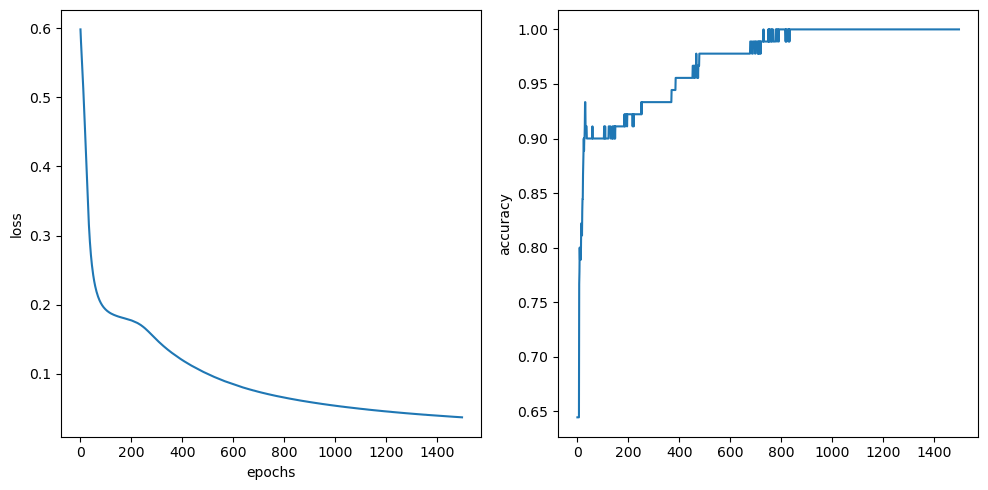

In [271]:
# plot the loss and accuracy as function of the epoch number
'''YOUR CODE GOES HERE '''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(total_losses)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')

ax2.plot(total_accuracies)
ax1.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

plt.tight_layout()
plt.show()

Below you find some code to plot the data and the model prediction. 

Text(0, 0.5, 'Normalized Score test 2')

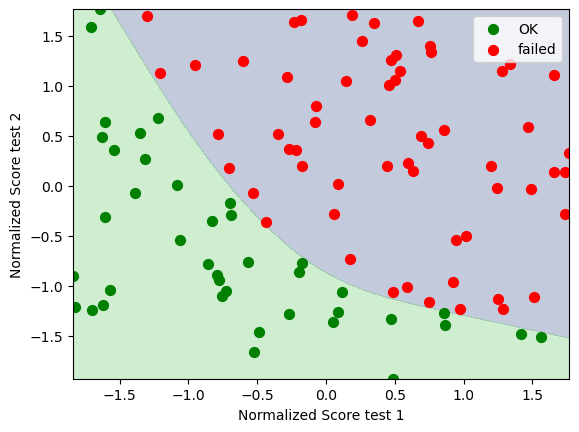

In [272]:
# visualize the results

# plot the model as a filled contour plot
# build mesh of gridpoints
x1_min, x1_max = X[0,:].min(), X[0,:].max()
x2_min, x2_max = X[1,:].min(), X[1,:].max()
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

# compute hypothesis on the meshgrid 
# first create a 2xM ndarray with the values of the scores on the mesh 
X_mesh = np.vstack((xx1.ravel(), xx2.ravel()))

# compute the output of the network
a1 = sigmoid(W1 @ X_mesh + b1)
a2 = softmax(W2 @ a1 + b2)
h = a2[0] # select either one of the two features
h = h.reshape(xx1.shape)

# plot the contour level(s)
levels = [0.0, 0.5, 1.0]
plt.contourf(xx1, xx2, h, levels, alpha=0.3)

# plot the data
mask = Y[0] == 1
plt.scatter(*X[:2, mask], s=50, c='g', marker='o', label='OK')
plt.scatter(*X[:2,~mask], s=50, c='r', marker='o', label='failed')
plt.legend()
plt.xlabel('Normalized Score test 1')
plt.ylabel('Normalized Score test 2')